# Preços de Imóveis em Natal
O objetivo desse notebook é criar um modelo a partir do algoritmos de *Machine Learning* (**Regressão Linear, Decision Tree, Random Forest, ...**) que possa criar uma estimativa dos preços de imóveis em Natal - RN. Esse valor será baseado em alguns atributos do imóvel.


# Dependências
Os seguintes *packages* externos são necesários:
- Matplolib (2.2.2)
- BeutifulSoup 4 (0.0.1)
- Pandas (0.23.4)
- Scikit-Learn (0.19.2)
- Requests (2.18.4)
- Folium (0.6.0)
- Seaborn (0.9.0)
- Plotly (3.2.0)


# Etapas
Esse projeto é divido nas partes que definem um problema de *Machine Learning* como mostrado na figura abaixo.
![Etapas do projeto.](https://i.imgur.com/Qza7Ym5.png)
Todas as etapas efetuadas na criação do modelo final foram abordadas abaixo. 

## 1. Obtenção os Dados
A primeira etapa é a adquirir os dados. Uma possibilidade seria utilizar um banco de dados já disponível. Entretanto, para o nosso objetivo iremos criar nosso próprio *dataset*, coletando dados da *web*. Para isso, as informações de imóveis a venda na região de Natal-RN foram retiradas do site [Viva Real](https://www.vivareal.com.br/). O site foi escolhido com base no maior número de resultados disponíveis para a região. Os dados foram adquiridos usando técnicas de *Web Scraping* da biblioteca `BeautifulSoup`. 
Primeiro ,importamos as bibliotecas usadas: **Pandas**, **Requests** e **BeutifulSoup**, e então os resultados são obtidos pela navegação ao longo das páginas de resultados do site. Isso é realizado pela função `navigate` descrita abaixo.

In [0]:
from bs4 import BeautifulSoup
import pandas as pd
import requests

def navigate(main_url, page_initial, page_final=500, df=pd.DataFrame()):
    """
    Requests many websites alterating the page result in the url.
    OBS.: the page_initial should be in the main_url.
    > main_url: the complete url of the search result.
    > page_initial: numeric value of te initial page search result.
    > page_final: the final page to navigate
    > df: Dataframe which value will be saved on.
    """
    # Spit URL in static and dynamic parts
    url_splitted = main_url.split('pagina=' + str(page_initial))
    url_static = url_splitted[0] + 'pagina='
    url_dynamic = str(page_initial) + url_splitted[1]
    
    # Initial position
    curr_page = page_initial
    
    # Go through all URLs
    while True:
        # URL being explored
        url = url_static + url_dynamic
        webpage = requests.get(url)    
        
        # Page not found interrupter
        if (not webpage.ok):
            #raise Exception('Page could not be accessed. HTML error code: ', webpage.status_code)
            print('Page could not be accessed. HTML error code: {}'.format(webpage.status_code))
            break
        
        # Final page reached interrupt
        if curr_page > page_final:
            print("Navigation reached the last result page.")
            break
        
        # Append the gathered data
        df = df.append(get_and_clean_data(webpage))

        # Edit URL
        curr_page += 1
        url_dynamic = str(curr_page) + url_splitted[1]
        
    # Return df
    return df

A função `get_and_clean_data` coleta os dados da *webpage* de resultado da busca. Essa função é específica para o site de **Viva Real** já que ela considera como os resultados são mostrados nesse site em específico, ou seja, para outra **URL** seria necessário outra função. Alguns operações são realizadas nos dados como transformá-los em númericos ou texto. Adicionalmente, uma função auxiliar `get_position` foi criada para retonar os valores que estão disponíveis no resultado.

In [0]:
def get_position(navi_tree, string=True):
    """
    Check if the bs4 navigation tree has a value and return its value.
    > navi_tree: navigation tree of bs4.
    < value in the navigation tree.
    """
    try:
        value = navi_tree.string
    except:
        value = None
    return value

def get_and_clean_data(page):
    """
    Collects and cleans property information from 'Vila Real' website, for a given search result webpage.
    > page: result webpage with the information. Result from request.get(url).
    < df: return a Pandas Dataframe with the information collected.
    """

    # BeautifulSoup object
    soup = BeautifulSoup(page.text, 'html.parser')

    # Main data holder
    list_of_dicts = []

    # Verifying results per page
    results_list = soup.find_all("div", class_="js-card-selector")
    assert(len(results_list) == 36)

    # Only results tags
    for tag in results_list:    

        # Dictionary to save results
        data = dict()
        final_position = tag.find("article")
        
        # Type of Property
        type_value = final_position.h2.a['href']
        if "apartamento" in type_value:
            data['type']='apartment'
        elif "casa" in type_value:
            data['type']='house'
        else:
            data['type']='other'
        
        # Address
        data['address'] = get_position(final_position.find("span", class_="js-property-card-address"))

        # Price
        data['price'] = get_position(final_position.find("div", class_="js-property-card-prices"))

        # Condo
        data['condo'] = get_position(final_position.section.find("strong", class_="js-condo-price"))

        # Area
        area_pos = final_position.find("li", class_="property-card__detail-area")
        data['area'] = get_position(area_pos.find("span", class_="property-card__detail-value"))
        
        # Bedrooms
        bedrooms_pos = final_position.find("li", class_="property-card__detail-room")
        data['bedrooms'] = get_position(bedrooms_pos.find("span", class_="property-card__detail-value"))
        
        # Suites
        suites_pos = final_position.find("li", class_="property-card__detail-item-extra")
        if suites_pos:
            data['suites'] = get_position(suites_pos.find("span", class_="property-card__detail-value"))
        else:
            data['suites'] = None

        # Bathrooms
        bath_pos = final_position.find("li", class_="property-card__detail-bathroom")
        data['bathrooms'] = get_position(bath_pos.find("span", class_="property-card__detail-value"))
        
        # Parking Spots
        park_pos = final_position.find("li", class_="property-card__detail-garage")
        data['parking_spots'] = get_position(park_pos.find("span", class_="property-card__detail-value"))
        
        list_of_dicts.append(data)

    # Create Pandas DataFrame Objects
    df = pd.DataFrame(list_of_dicts)

    # Clean DataFrame - Convert numeric values and clean strings
    string_cols = ['address', 'type']
    price_cols = ['price', 'condo']
    numeric_cols = df.columns.drop(string_cols)

    # Remove unwanted symbols from price
    for col in price_cols:
        df[col] = df[col].str.strip()
        df[col] = df[col].replace('\D', '', regex=True)
    
    # Convert to numeric
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce', downcast='integer')

    # Clean spaces from string values
    for col in string_cols:
        df[col] = df[col].str.strip()

    return df

Assim, podemos criar um *dataframe* dos resultados para uma busca no site **Viva Real**. Entretanto, para se obter todos os resultados para Natal o tempo de execução é razoavelmente grande (~15 minutos). Dessa maneira, iremos criar um *dataframe* com apenas os valores das primeira página de resultados. Para agilidade, iremos usar esse pequeno *dataframe* como exemplo ao longo de todo o **[Tópico 1](#1.-Obten%C3%A7%C3%A3o-os-Dados)** desse notebook. 

In [0]:
URL = 'https://www.vivareal.com.br/venda/rio-grande-do-norte/natal/?pagina=1'

results_df = navigate(URL, 1, 1)
print(results_df.head())

Navigation reached the last result page.
                                             address   area  bathrooms  \
0  Rua Desembargador Hemetério Fernandes, 1162 - ...  112.0        3.0   
1  Rua Princesa Isabel, 180 - Cidade Alta, Natal ...    NaN        3.0   
2           Rua Mipibu, 741 - Petrópolis, Natal - RN  103.0        1.0   
3  Rua Joaquim Eduardo de Farias, 213 - Ponta Neg...   57.0        2.0   
4  Avenida Capitão-Mor Gouveia, 2730 - Lagoa Nova...  161.0        2.0   

   bedrooms  condo  parking_spots     price  suites       type  
0       3.0  600.0            2.0  750000.0     1.0  apartment  
1       3.0    NaN            2.0       NaN     NaN      other  
2       3.0  520.0            2.0  465000.0     1.0  apartment  
3       2.0  268.0            1.0  170000.0     1.0  apartment  
4       3.0  390.0            3.0  399000.0     1.0  apartment  


Podemos perceber que alguns valores não foram convertidos corretamente e possui valores `NaN` e devem ser tratados mais adiante. Além disso, temos as informações que foram retiradas do site organizadas nas 9 colunas:
- **address**: Endereçodo imóvel.
- **area**: Áre do imóvel [m²].
- **bathrooms**: Quantidade de banheiros.
- **bedrooms**: Quantidade de quartos.
- **condo**: Preço do condimínio [R\$].
- **parking_spots**: Número de vagas de estacionamento.
- **price**: Valor do imóvel [R\$].
- **suites**: Quantos quartos são suites.
- **type**: Tipo de imóvel: `house`, `apartment` e `other`.

## 2. Preparação dos Dados
### 2.1 - Limpeza e Melhorarias dos Dados

Uma rápida descrição dos dados, nos mostra que vários dados estão faltando. Além disso, o campo 'address' contém uma das características mais importantes do imóvel (sua localização), porém não é um campo facilmente utilizado como um atributo.

In [0]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 9 columns):
address          36 non-null object
area             32 non-null float64
bathrooms        33 non-null float64
bedrooms         35 non-null float64
condo            23 non-null float64
parking_spots    32 non-null float64
price            31 non-null float64
suites           29 non-null float64
type             36 non-null object
dtypes: float64(7), object(2)
memory usage: 2.6+ KB


Assim, devemos **limpar** e **melhorar** os dados.

Isso consiste em 4 etapas:
- Remover observações duplicadas (geradas por redirecionamento do site).
- Deliberar os valores faltando da seguinte maneira:
    - Remover as observações que possui dados faltando nas colunas 'price','address', 'area' e 'type'.
    - Substitui os valores faltando por `0` nas colunas 'bathrooms', 'bedrooms', 'condo', 'parking_spots', 'suites', 'condo'.
- Adiciona as colunas 'lat' e 'lon' com base no endereço do imóvel.
- Remover a coluna 'address' e as observações que não se conseguiu se obter a latitude e longitude.

Essas etapas são implementadas pela função `clean_improve_df` descrita abaixo. A função auxiliar `address2coord` transforma o endereço do imóvel em coordenadas usando a API Open Source [Nomatim](https://nominatim.openstreetmap.org). O resultado final é um *dataframe* **limpo** no sentido de ruídos da coleta dos dados.

In [0]:
import pandas as pd
import numpy as np
import math
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import json
import matplotlib.pyplot as plt
from time import sleep


def address2coord(address):
    """
    Return the latitude and longitude from given address. Uses Free Nomatim OpenStreetMap API.
    OBS.: Super slow...zZz
    > address: string with the address.
    < (lat, lon): tuple with latitude and longitude of the address.
    """
    # Organize address
    address = address.replace(' ', '+')   

    # Nominatim API
    api_url = "https://nominatim.openstreetmap.org/search?&format=json&q="
    
    # 'requests' retry features 
    session = requests.Session()
    adapter = HTTPAdapter(max_retries=Retry(20, backoff_factor=.5))
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    
    # Get the response
    r = session.get(api_url + address)
    
    # Load as json
    try:
        json_as_list = json.loads(r.content)
    except:
        print("API blocked. Message: {}".format(r.content))
    
    # Consider only the first result
    try:
        json_as_dict = json_as_list[0]
    # If no result is found
    except:
        json_as_dict = {'lat':0, 'lon':0}

    # Retrieve 'lat' and 'lon' from json dictionary
    latitude = float(json_as_dict['lat'])
    longitude = float(json_as_dict['lon'])

    return (latitude, longitude)

# adr = "Rua Desembargador Hemetério Fernandes, 1162 - Tirol, Natal - RN"
# print(address2coord(adr))

def clean_improve_df(file="DataSet_Natal.csv"):
    """
    Apply address2coord to every entry in 'address' and append results to a new column of the DataFrame.
    Briefly, this function cleans the data performing the following steps:
    1 - Remove duplicates
    3 - Remove empty entries of columns 'price','address', 'area' and 'type'.
    4 - Add 'lat' and 'lon' columns
    5 - Drop 'address' column

    > file:name of the .csv  file  or df object.
    < multiple .csv files with cleaned dataframes, added 'lat' and 'lon' columns
    and removed 'address' column.
    OBS.: The conversion of addresses in coordenates is supper slow. Took ~3 hours 
    for ~8000 addresses conversions.
    """
    
    # Load DataFrame from file
    if not isinstance(file, pd.DataFrame):
        df = pd.read_csv(file)
    else:
        df = file
    
    # Remove duplicates and reindex
    df.drop_duplicates(inplace=True)
    df = df.reset_index(drop=True)

    # Remove entries with missing values from prices , area, type and address
    df = df.dropna(subset=['price','address', 'area','type'])
        
    #df.to_csv("DataSet_Natal_Clean.csv", index=False)

    # Split df in n parts of maximum 1000 observations due to API limit 
    n = math.ceil(len(df) / 1000)
    df_splitted = np.array_split(df, n)
    
    for i, df_piece in enumerate(df_splitted): 
        # Get latitude and longitude
        coord_series = df_piece['address'].apply(address2coord) # Series
        df_piece['lat'] = coord_series.apply(lambda x: x[0])    # Lat column
        df_piece['lon'] = coord_series.apply(lambda x: x[1])    # Lon column
        
        # Remove entries with missing values from prices , area, type, lat, lon and address
        df_piece = df_piece.dropna(subset=['lat', 'lon'])

        # Replace missing values from bathrooms, bedrooms, condo, parking_spots, suites, condo with zero
        fill_cols = ['bathrooms', 'bedrooms', 'condo', 'parking_spots', 'suites', 'condo']
        df_piece[fill_cols] = df_piece[fill_cols].fillna(0)

        # Drop address column
        df_piece = df_piece.drop(['address'], axis=1)

        #print(df_piece.head(50))

        # Reset index again         
        df_piece = df_piece.reset_index(drop=True)

        # Save partial df
        df_piece.to_csv("DataSet_Natal_Clean_" + str(i) +".csv", index=False)

        # Wait for next acquisition - 3 min
        #sleep(180)
    
    # Join results dataframes
    return join_dataframes("DataSet_Natal_Clean_", n)

def join_dataframes(file_static, n):
    """
    Join multiple .cvs files created previously, removing unsuccessful 'lat' and 'lon' coordenates.  
    > file: begin of the .csv file name.
    > n: number of files.
    < one .csv file with the final DataFrame and dataframe itself.
    """
    # Placeholder
    df = pd.DataFrame()
    # Read all files and append them together
    for i in range(n):
        df_piece = pd.read_csv(file_static + str(i) + ".csv")
        df_piece = df_piece[(df_piece.lat != 0) & (df_piece.lon != 0)]
        df = df.append(df_piece)
    
    # Save result as csv
    #df.to_csv("DataSet_Natal_Final.csv", index=False)

    return df

Aplicando essas funções nos dados obtidos anteriormente, `results_df`, temos os seguintes resultados:
**OBS.: A função `address2coord` é muito lenta, pois ela depende do tempo de resposta da API Nomatim. Note que, mesmo para esse pequeno *dataframe*, o tempo de execução é de ~20 segundos.**

In [0]:
clean_df = clean_improve_df(results_df)
# Visualização
clean_df.info()
clean_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25 entries, 0 to 30
Data columns (total 10 columns):
area             25 non-null float64
bathrooms        25 non-null float64
bedrooms         25 non-null float64
condo            25 non-null float64
parking_spots    25 non-null float64
price            25 non-null float64
suites           25 non-null float64
type             25 non-null object
lat              25 non-null float64
lon              25 non-null float64
dtypes: float64(9), object(1)
memory usage: 2.1+ KB


,area,bathrooms,bedrooms,condo,parking_spots,price,suites,type,lat,lon
0,112.0,3.0,3.0,600.0,2.0,750000.0,1.0,apartment,-5.799795,-35.197975
1,103.0,1.0,3.0,520.0,2.0,465000.0,1.0,apartment,-5.787058,-35.198381
2,57.0,2.0,2.0,268.0,1.0,170000.0,1.0,apartment,-5.879670,-35.197356
3,161.0,2.0,3.0,390.0,3.0,399000.0,1.0,apartment,-5.827470,-35.216856
4,236.0,5.0,4.0,795.0,3.0,1100000.0,3.0,other,-5.825373,-35.211364


### 2.2 Manipulação dos Dados
Agora que os dados obtidos já estão organizados e sem valores faltando podemos realizar a *EDA (Exploratory Data Analysis)*. Primeiramente, vamos visualizar as características dos dados.

**OBS.:A partir de agora iremos usar o *dataframe* com todos os dados obtidos, disponível no arquivo "DataSet_Natal_Final.csv". **

**Esses dados foram coletados *offline* devido ao grande tempo de execução (>4h). Porém, as funções utilizadas estão listadas nas etapas anteriores. **

In [0]:
# Get the data
data = pd.read_csv("DataSet_Natal_Final.csv")

# Brief view of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6988 entries, 0 to 6987
Data columns (total 10 columns):
area             6988 non-null float64
bathrooms        6988 non-null float64
bedrooms         6988 non-null float64
condo            6988 non-null float64
parking_spots    6988 non-null float64
price            6988 non-null float64
suites           6988 non-null float64
type             6988 non-null object
lat              6988 non-null float64
lon              6988 non-null float64
dtypes: float64(9), object(1)
memory usage: 546.0+ KB


 No total temos **6988** observações e **10** colunas de atributos, além de nenhum dado faltando. Temos 9 colunas numéricas e uma categórica. Então, deve-se adicionar o tipo `categorical` para a coluna `type`.
 
Além disso, para termos uma melhor idéia dos valores, podemos analisar algumas **estatísticas** dos dados e seus **histogramas**.

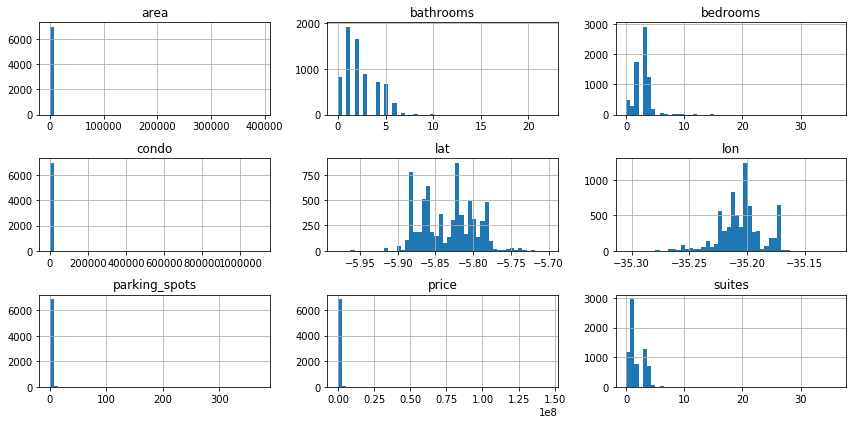

In [0]:
# Set `type` as categorical
data['type'] = data.type.astype('category')
# Statistics
data.hist(bins=50, figsize=(12, 6))
data.describe()
plt.tight_layout()

Aqui podemos ver alguns problemas nos dados:
- Todas as colunas numéricas com exceção de `lat` e `lon` possui valores máximos no mínimo questionáveis.
- A coluna `area` possui valor mínimo impossível.

Basicamente, esses problemas são causado por **outliers** que podem ser desde erros de digitação do anúncio no site, até uma observação real muito distinta (ex. um condomínio inteiro a venda).

### 2.2.1 - Valores Máximos
Para resolver esse problema, iremos primeiro filtrar esses valores usando o método `quantile` de cada coluna para encontrarmos o valor que engloba 99.5% das observações. Assim, podemos avaliar melhor se os valores máximo são realmente *outliers*.

In [0]:
# Quantiles for each column
quantiles_99 = data.quantile(0.995, axis=0)

quantiles_99

area             3.064835e+03
bathrooms        8.000000e+00
bedrooms         1.000000e+01
condo            2.500000e+03
parking_spots    1.000000e+01
price            5.120065e+06
suites           7.000000e+00
lat             -5.741886e+00
lon             -3.517222e+01
Name: 0.995, dtype: float64

Logo, podemos limitar observações baseando-se nesses valores de `percentile` encontrados para cada coluna. Adicionamente, vamos acrescentar uma margem de **15%** para evitar que valores possivelmente factíveis sejam excluídos.

In [0]:
# Add margins
quantiles_99['area'] *= 1.15
quantiles_99['bathrooms'] *= 1.15
quantiles_99['bedrooms'] *= 1.15
quantiles_99['condo'] *= 1.15
quantiles_99['parking_spots'] *= 1.15
quantiles_99['price'] *= 1.15
quantiles_99['suites'] *= 1.15
# Outliers for each column
data_out = data[(data['area'] > quantiles_99['area']) | (data['area'] > quantiles_99['area']) |
                (data['bathrooms'] > quantiles_99['bathrooms']) | (data['bedrooms'] > quantiles_99['bedrooms']) | 
                (data['condo'] > quantiles_99['condo']) | (data['parking_spots'] > quantiles_99['parking_spots']) |
                (data['price'] > quantiles_99['price']) | (data['suites'] > quantiles_99['suites'])
                ]
# Outliers
data_out.head()

,area,bathrooms,bedrooms,condo,parking_spots,price,suites,type,lat,lon
43,120.0,3.0,3.0,710000.0,3.0,580000.0,2.0,apartment,-5.782946,-35.200421
87,55.0,1.0,2.0,49620.0,1.0,493000.0,0.0,other,-5.881194,-35.178718
151,641.0,16.0,13.0,0.0,1.0,2300000.0,0.0,other,-5.878496,-35.175262
304,4000.0,0.0,0.0,1.0,0.0,600000.0,0.0,other,-5.845384,-35.258634
369,44.0,1.0,2.0,280000.0,1.0,139000.0,0.0,apartment,-5.884266,-35.173685


Para agilizar o processo, esse valores foram simplesmente **removidos**. É uma escolha **conservadora**, porém razoável. Idealmente, deveríamos analisar as observações extremas individualmente, e assim, verificar se elas fariam sentido. Apesar disso não ter sido feito, muitas das observações de fato pareciam erros de digitação. Por exemplo, o anúncio do índice **43**: um apartamento de **120 m²** e **3 quartos**, mas que o condomínio custa **R$ 710.000**. 
Com essa escolha mais **conservadora**, devemos ter em mente que algumas observações válidas podem terem sido efetivamente removidas.

A remoção dessas entradas poderia ser feitas pela negação do `boolean indexing`, por filtro ou removendo a interseção dos *dataframes*. Efetuando essa remoção e fazendo uma reanálise dos dados após a remoção, ficamos com um resultado bem mais razoável para os valores máximos.

In [0]:
# Remove Outliers
data = pd.concat([data, data_out]).drop_duplicates(keep=False)
data.describe()

,area,bathrooms,bedrooms,condo,parking_spots,price,suites,lat,lon
count,6753.000000,6753.000000,6753.000000,6753.000000,6753.000000,6.753000e+03,6753.000000,6753.000000,6753.000000
mean,163.652451,2.298682,2.743077,369.796535,2.044129,5.704985e+05,1.675404,-5.833620,-35.204703
std,183.483767,1.693159,1.209855,487.256728,1.469015,5.817735e+05,1.311434,0.034932,0.018510
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.500000e+04,0.000000,-5.979417,-35.304840
25%,60.000000,1.000000,2.000000,0.000000,1.000000,2.500000e+05,1.000000,-5.863309,-35.214127
50%,109.000000,2.000000,3.000000,230.000000,2.000000,4.000000e+05,1.000000,-5.826920,-35.202387
75%,200.000000,3.000000,3.000000,580.000000,3.000000,6.800000e+05,3.000000,-5.803210,-35.196726
max,3337.000000,9.000000,10.000000,2800.000000,11.000000,5.822490e+06,8.000000,-5.701433,-35.123328


### 2.2.2 -  Valores Mínimos
Para os valores mínimos, algo semelhante foi feito. Porém apenas para a coluna `area`.


In [0]:
# Quantiles
area_quantiles_0005 = data['area'].quantile(0.005)
print(area_quantiles_0005)

# Filter data percentile + 20%
data_out = data[(data['area'] < area_quantiles_0005 * 1.2)]

# Remove Outliers
data = pd.concat([data, data_out]).drop_duplicates(keep=False)
data.describe()


24.0


,area,bathrooms,bedrooms,condo,parking_spots,price,suites,lat,lon
count,6682.000000,6682.000000,6682.000000,6682.000000,6682.000000,6.682000e+03,6682.000000,6682.000000,6682.000000
mean,165.146812,2.314128,2.767435,372.106405,2.057169,5.743698e+05,1.690213,-5.833493,-35.204797
std,183.878776,1.694424,1.191234,488.557268,1.467615,5.828349e+05,1.309627,0.034920,0.018476
min,29.000000,0.000000,0.000000,0.000000,0.000000,1.500000e+04,0.000000,-5.979417,-35.304840
25%,63.000000,1.000000,2.000000,0.000000,1.000000,2.500000e+05,1.000000,-5.863309,-35.214323
50%,110.000000,2.000000,3.000000,233.500000,2.000000,4.000000e+05,1.000000,-5.826920,-35.202387
75%,200.000000,3.000000,3.000000,580.000000,3.000000,6.800000e+05,3.000000,-5.803210,-35.196726
max,3337.000000,9.000000,10.000000,2800.000000,11.000000,5.822490e+06,8.000000,-5.701433,-35.123328


Reanalisando as **Estastísticas** e **Histogramas** iniciais, temos um resultado bem mais realístico. Além de que, o número de observações diminui razoavelmente pouco, de **6988** para **6682**.

,area,bathrooms,bedrooms,condo,parking_spots,price,suites,lat,lon
count,6682.000000,6682.000000,6682.000000,6682.000000,6682.000000,6.682000e+03,6682.000000,6682.000000,6682.000000
mean,165.146812,2.314128,2.767435,372.106405,2.057169,5.743698e+05,1.690213,-5.833493,-35.204797
std,183.878776,1.694424,1.191234,488.557268,1.467615,5.828349e+05,1.309627,0.034920,0.018476
min,29.000000,0.000000,0.000000,0.000000,0.000000,1.500000e+04,0.000000,-5.979417,-35.304840
25%,63.000000,1.000000,2.000000,0.000000,1.000000,2.500000e+05,1.000000,-5.863309,-35.214323
50%,110.000000,2.000000,3.000000,233.500000,2.000000,4.000000e+05,1.000000,-5.826920,-35.202387
75%,200.000000,3.000000,3.000000,580.000000,3.000000,6.800000e+05,3.000000,-5.803210,-35.196726
max,3337.000000,9.000000,10.000000,2800.000000,11.000000,5.822490e+06,8.000000,-5.701433,-35.123328


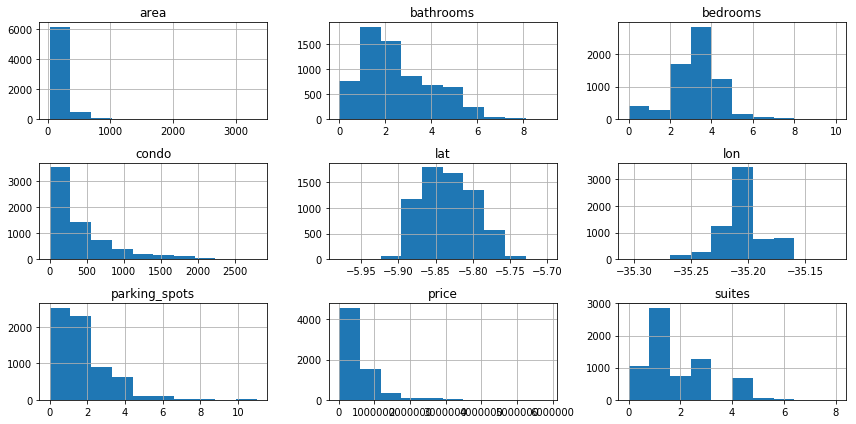

In [0]:
# Statistics
data.hist(bins=10, figsize=(12, 6))
plt.tight_layout()
data.describe()

### 2.3 Separação dos Conjuntos de Teste e Treinamento
A separação foi feita de maneira que 20% do dataset foi separado para teste posteriormente. Os dataset foram salvos nos *dataframes* `train_set` e `test_set`.

In [0]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, 
                                       test_size=0.2, 
                                       random_state=35)

print("data has {} instances\n {} train instances\n {} test instances".
      format(len(data),len(train_set),len(test_set)))

data has 6682 instances
 5345 train instances
 1337 test instances


## 3. Explorar e Visualizar os Dados
Agora que já separamos os dados, vamos procurar ***insights*** nos dados de treinamento. Inicialmente, vamos criar uma cópia e realizar algumas visualizações.

In [0]:
train = train_set.copy()

### 3.1 Visualização dos Dados Geográficos
- **Usando `Matlplotlib`**

Como temos dados geográficos podemos plotá-lo para termos uma melhor representação dos dados. 

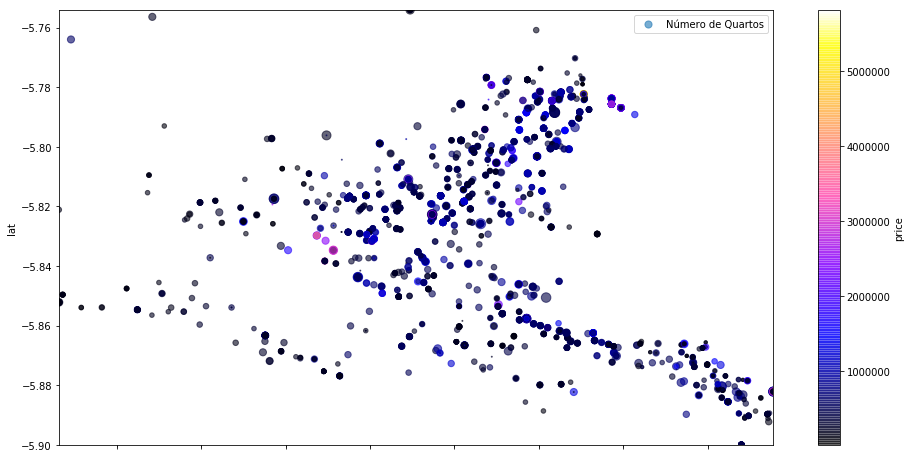

In [0]:
# Visualization
train.plot(kind="scatter", x="lon", y="lat", alpha=0.6,
           s=train["bedrooms"]*10+1, label="Número de Quartos",
           c="price", cmap=plt.get_cmap("gnuplot2"), colorbar=True, 
           figsize=(16, 8), xlim=(train['lon'].quantile(.01), train['lon'].quantile(.99)),
           ylim=(train['lat'].quantile(.01), train['lat'].quantile(.99)))
plt.legend()

- **Utilizando `Folium`**

Para termos uma noção melhor da localização dos imóveis podemos visualizá-los usando a biblioteca `folium`. Como resultado temos um mapa dinâmico que mostra a localização dos imóveis agrupado de acordo com o zoom definido.

In [0]:
import folium
from folium import plugins
from matplotlib.cm import get_cmap
from matplotlib.colors import to_hex, Normalize

# Folium's Map object
m = folium.Map(location=[-5.812757, -35.255127], zoom_start=12)

# Sub-dataframe used
df = train[['lat', 'lon', 'price', 'area']]
marker_cluster = plugins.MarkerCluster().add_to(m)

# Colormap from matplotlib
#cm = get_cmap('hsv')
# Normalization
#norm = Normalize(vmin=df['price'].min(), vmax=df['price'].max())

# Iterate over df 
for i, obs in df.iterrows():
    folium.Marker( location=[ obs['lat'], obs['lon'] ]).add_to(marker_cluster)
### Doesn't show in notebook, but shows in saved file ??
#     folium.CircleMarker(
#     radius=max(obs['area'] / 25, 8),
#     location=[obs['lat'], obs['lon']],
#     color=to_hex(cm(norm(obs['price']))),
#     fill=False,
#     ).add_to(marker_cluster)

### Doesn't show in notebook, but shows in saved file ???
#heat_data = [[row['lat'], row['lon']] for index, row in train.iterrows()]
#plugins.HeatMap(heat_data).add_to(m)

# Visualization and saving
m.save( 'm.html')
m


### 3.2 Procurando Correlações
O **Coeficiente de Correlação Linear de Pearson** pode ser calculado entre todo o *dataframe* facilmente através do método `corr`. No nosso caso, a coluna de interesse é `price`.

In [0]:
corr_matrix = train.corr()
corr_matrix['price'].sort_values(ascending=False)

price            1.000000
area             0.582362
suites           0.515059
parking_spots    0.449734
bathrooms        0.354980
bedrooms         0.308745
condo            0.225720
lat              0.207288
lon              0.071361
Name: price, dtype: float64

Todos os atributos tiveram coeficientes positivos em relação ao preço. Com exeção da `lat` e `lon`, isso faz sentido uma vez que quanto maior o número de quartos, banheiro, suites, condomínio, área ou estacionamentos; maior se espera do valor do imóvel.

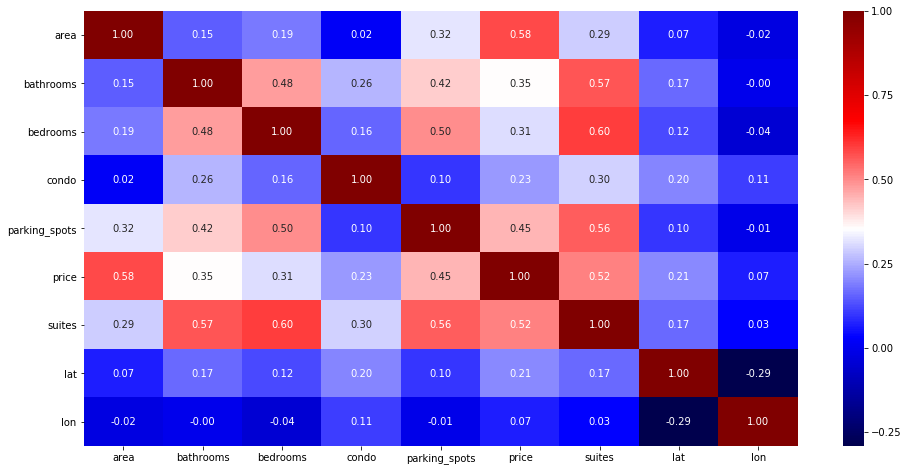

In [0]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(16, 8))

sns.heatmap(corr_matrix, ax=ax, annot=True, fmt=".2f", cmap=plt.get_cmap('seismic'))

Alternativamente,podemos usar `Seaborn`'s `pairplot` que nos dará uma melhor visualização da correlação linear dos resultados.

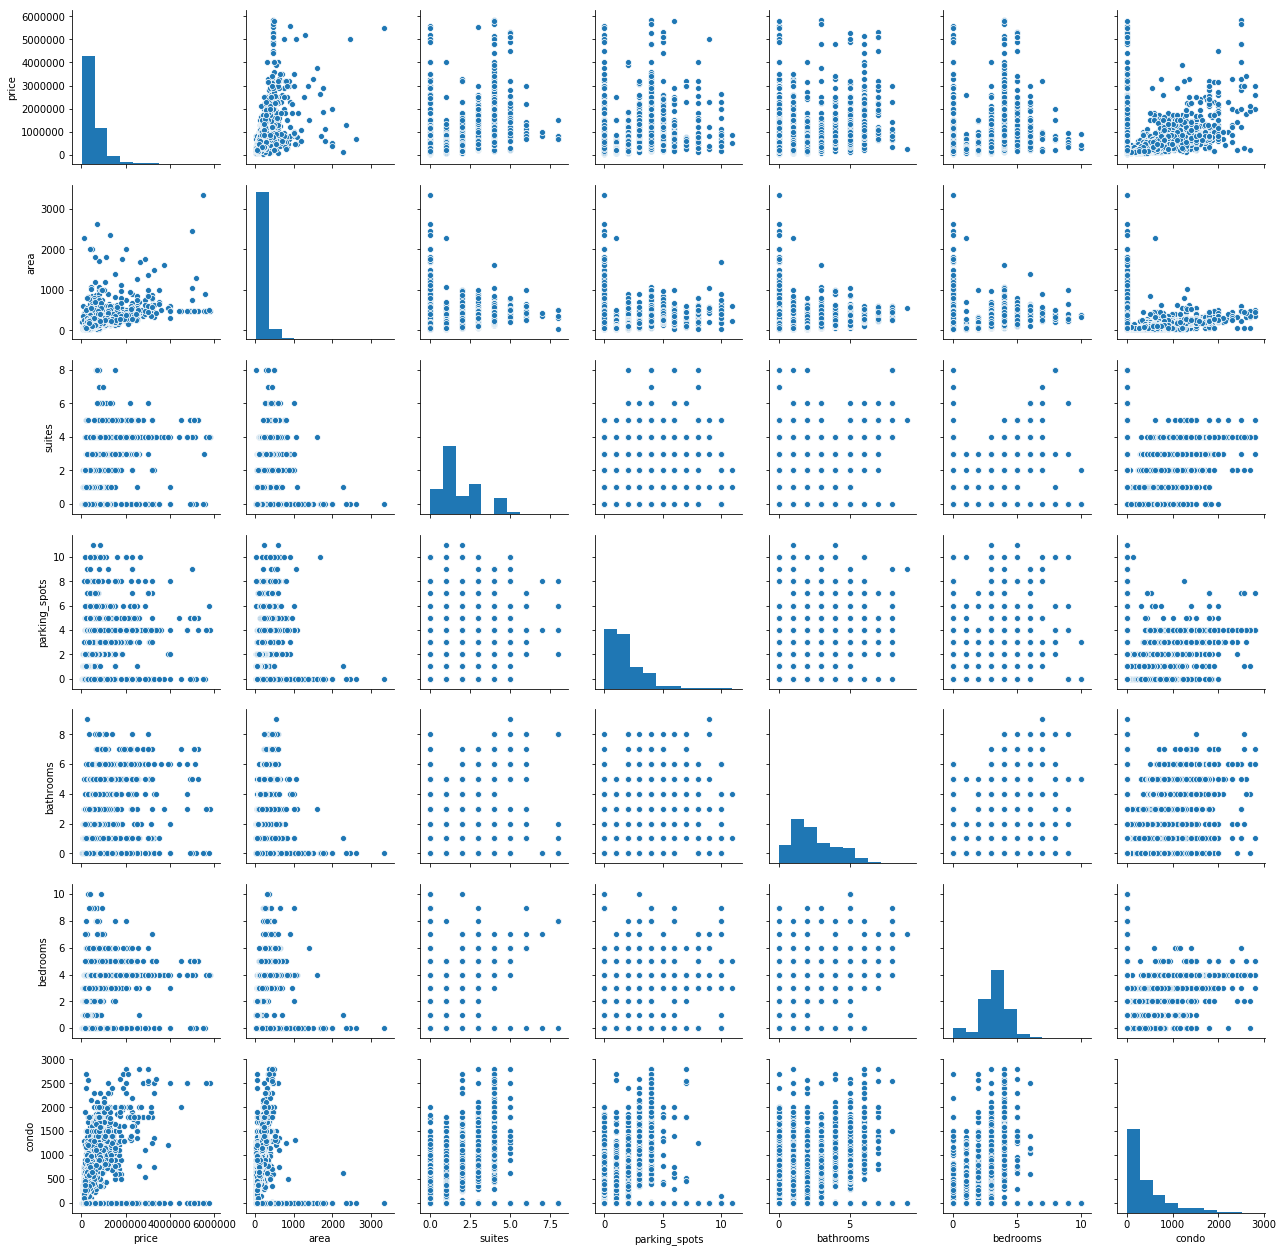

In [0]:
columns = ['price', 'area', 'suites', 'parking_spots', 'bathrooms', 'bedrooms', 'condo']
sns.pairplot(train[columns], diag_kind='hist')

Aqui podemos obeservar que por alguns atributos serem discretos, temos esses espaços no gráficos.


Como o atributo mais relacionado com o `price` é `area`, vamos visualizar melhor o *scatterplot* desses dois valores em um gráfico interativo. Para isso usamos o `pyplot`.

In [0]:
# plotly online requires login and password
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# Functions needed for colab plotly
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

# basic functions to run on google colab
configure_plotly_browser_state()
init_notebook_mode(connected=False)

# create a generic layout
layout = go.Layout(width=900,height=600,
                  xaxis=dict(title='Área'),
                  yaxis=dict(title='Preço')) 

# generate a scatter
trace = [go.Scatter(
    y=train["price"], 
    x=train["area"],
    mode = 'markers')]

# create a figure and plot in notebook. 
fig = go.Figure(data=trace,layout=layout)
pyo.iplot(fig)

Podemos ver que a até **1000 m²** existe uma forte correlação, mas a partir de desse valor as observações ficam mais dispersas. Também nota-se que os imóveis mais caros são até **500 m²**.

### 3.3 Combinação de Atributos (*Cross-Featuring*)
Todos os atributos tiveram valores razoáveis de **Correlação de *Pearson***. Porém, talvez o possamos encontrar um combinação de features que represente uma melhor correlação. Assim, vamos tentar os seguintes atributos combinados:
 - Quartos por área.
 - Valor do condomínio por área.

In [0]:
# attribute combinations
train["bedrooms_per_area"] = train["bedrooms"] / train["area"]
train["condo_per_area"] = train["condo"] / train["area"]

train_correlation_matrix = train.corr()
print(train_correlation_matrix["price"].sort_values(ascending=False))

# Ignoring atribute comination
train.drop('condo_per_area', axis=1, inplace=True)
print(train.head())


price                1.000000
area                 0.582362
suites               0.515059
parking_spots        0.449734
bathrooms            0.354980
bedrooms             0.308745
condo                0.225720
lat                  0.207288
lon                  0.071361
condo_per_area      -0.126286
bedrooms_per_area   -0.477009
Name: price, dtype: float64
       area  bathrooms  bedrooms  condo  parking_spots     price  suites  \
4349  114.0        3.0       3.0    0.0            2.0  570000.0     1.0   
6584   85.0        2.0       3.0  370.0            2.0  495000.0     1.0   
220    56.0        2.0       2.0  235.0            1.0  199000.0     1.0   
4552   70.0        2.0       2.0  250.0            1.0  170000.0     0.0   
6543   50.0        1.0       2.0    0.0            1.0  200000.0     0.0   

           type       lat        lon  bedrooms_per_area  
4349  apartment -5.851905 -35.209464           0.026316  
6584  apartment -5.857640 -35.201449           0.035294  
220   apart

Com essa técnica conseguimos criar **dois atributos** que possuem **correlação negativa** com nossa variável de controle `price`. Temos os seguintes resultados:
 - O novo atributo `condo_per_area`teve valor absoluto **inferior** ao atributo `condo` sozinho e será **desconsiderado**.
 - O atributo `bedrooms_per_area` teve um valor absoluto bem **superior** ao de `bedrooms` sozinho, o que mostra que casas que possuem mais quartos por metro quadrado tendem a ser mais baratas. Ou seja, provavelmente, outros cômodos possuem maior influência no valor da casa.

## 4. Preparando os Dados para Algoritmos de *Machine Learning*
### 4.1 Dados Faltando
Já efetuamos a etapa de limpeza no nossos dados no [Tópico 2](#2.-Preparação-os-Dados). Assim, iremos criar o vetor de *features* **X** e os valores esperado **Y**. Além disso, vamos confirmar que não há nenhum valor faltando na nosso vetor de  entrada **X**. 

In [0]:
# drop creates a copy of the remain data and does not affect train_set
train_X = train_set.drop("price", axis=1)

# copy the label (y) from train_set
train_y = train_set.price.copy()

# count the number of missing values
train_X.isnull().sum()

area             0
bathrooms        0
bedrooms         0
condo            0
parking_spots    0
suites           0
type             0
lat              0
lon              0
dtype: int64

Agora, iremos chamar os objetos do módulo `scikit-learn` responsável em armazenar os valores médios dos atributos, para caso exista a necessidade de substituir o valores faltando no futuro. Além de termos o registro constante da mediana que está sendo utilizada na subtituição de dados faltando.

In [0]:
# First, you need to create an Imputer instance, specifying that you want 
# to replace each attribute’s missing values with the median of that attribute:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")

# Since the median can only be computed on numerical attributes, we need to 
# create a copy of the data without the text attribute type:
train_X_num = train_X.drop("type", axis=1)

# Now you can fit the imputer instance to the training data using 
# the fit() method:
imputer.fit(train_X_num)

# Now you can use this “trained” imputer to transform the training set by 
# replacing missing values by the learned medians:
train_X_num_array = imputer.transform(train_X_num)

# The result is a plain Numpy array containing the transformed features. 
# If you want to put it back into a Pandas DataFrame, it’s simple:
train_X_num_df = pd.DataFrame(train_X_num_array, columns=train_X_num.columns)

imputer.statistics_

array([110.       ,   2.       ,   3.       , 230.       ,   2.       ,
         1.       ,  -5.8258062, -35.2023839])

Aplicamos a subtituição dos valores faltando usando a mediana armazenada no imputer. Nesse caso, isso não fará nada, pois não há valores faltando. Porém isso irá automatizar essa escolha em banco de dados **futuros**. 

### 4.2 Dados Categóricos
Para utilizarmos dados categóricos em algoritmos de *Machine Learning* devemos redefiní-los usando o método *One-hot Encoding*. Isso consiste em criar um atributo binário para cada categoria desse atributo. Isso também é feito por funções do pacote `scikit-learn`.

In [0]:
# For this, we can use Pandas' factorize() method which maps each 
# category to a different integer:

train_X_cat_encoded, train_X_categories = train_X.type.factorize()

# train_X_cat_encoded is now purely numerical
print(train_X_cat_encoded[0:30])

# Scikit-Learn provides a OneHotEncoder encoder to convert 
# integer categorical values into one-hot vectors.

from sklearn.preprocessing import OneHotEncoder 

encoder = OneHotEncoder()

# Numpy's reshape() allows one dimension to be -1, which means "unspecified":
# the value is inferred from the lenght of the array and the remaining
# dimensions
train_X_cat_1hot = encoder.fit_transform(train_X_cat_encoded.reshape(-1,1))

# it is a column vector
train_X_cat_1hot

[0 0 0 0 1 1 0 0 0 0 2 0 0 0 2 0 0 0 1 0 2 0 0 0 2 0 0 0 0 0]


<5345x3 sparse matrix of type '<class 'numpy.float64'>'
	with 5345 stored elements in Compressed Sparse Row format>

### 4.3 Tranformadores Customizáveis
O `scikit-learn` também possui maneiras de adicionar *Cross-features* criadas na fase de **EDA** de maneira automática através da criação do objeto `CombinedAttributesAdder`. Assim, para observações futuras que serão adicionadas ao *dataset* a mesma operação será realizada de forma automática.

In [0]:
# these classes will be useful later for automatic hyperparameter tuning 
from sklearn.base import BaseEstimator, TransformerMixin

# indices for the columns
bedrooms_ix, area_ix =  train_X.columns.get_loc("bedrooms"), train_X.columns.get_loc("area")

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):

  def __init__(self, add_bedrooms_per_area = True): # no *args or **kargs
    self.add_bedrooms_per_area = add_bedrooms_per_area
    
  def fit(self, X, y=None):
    return self # nothing else to do
  
  def transform(self, X, y=None):
    if self.add_bedrooms_per_area:
      bedrooms_per_area = X[:, bedrooms_ix] / X[:, area_ix]
      # Translates slice objects to concatenation along the second axis.
      return np.c_[X, bedrooms_per_area]
    else:
      return np.c_[X]

# Apply to train_X
attr_adder = CombinedAttributesAdder()
train_X_extra_attribs = attr_adder.transform(train_X.values)

# train_X_extra_attribs is a numpy array
# transforming it to a dataframe for better visualization
train_X_extra_attribs_df = pd.DataFrame(train_X_extra_attribs,
                                        columns=list(train_X.columns)+["bedrooms_per_area"])
train_X_extra_attribs_df.head()

,area,bathrooms,bedrooms,condo,parking_spots,suites,type,lat,lon,bedrooms_per_area
0,114,3,3,0,2,1,apartment,-5.85191,-35.2095,0.0263158
1,85,2,3,370,2,1,apartment,-5.85764,-35.2014,0.0352941
2,56,2,2,235,1,1,apartment,-5.89097,-35.1756,0.0357143
3,70,2,2,250,1,0,apartment,-5.85764,-35.2014,0.0285714
4,50,1,2,0,1,0,other,-5.86781,-35.181,0.04


### 4.4 Dimensionamento de Atributos
Normalmente, algoritmos de *Machine Learning* **convergem mais rapidamente** com dados **numéricos normalizados**. Assim, continuaremos usando `scikit-learn` para realizar esse redimensionamento dos atributos numéricos presentes no *dataset*.

Nesse caso iremos utilizar o `StandardScaler` que efetua a **normalização** dos dados, isto é, faz com que ele tenha média zero e variância unitária. Como iremos usar um método padrão, já podemos efetuar a sequência de transformações necessárias nos nosso dados.

### 4.5 Sequencia de Transformações
Enfim, Criando um objeto `Pipeline` podemos efetuar a sequência de tranformações listadas até agora no [Tópico 4](#4.-Preparando-os-Dados-para-Algoritmos-de-Machine-Learning) de uma só fez. Além disso, podemos criar uma classe `DataFrameSelector` que extrai as colunas de um *dataframe* como `numpy` arrays.

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from future_encoders import OneHotEncoder

# Pipeline for numeric atributes
num_pipeline = Pipeline([('imputer', Imputer(strategy="median")),
                         ('attribs_adder', CombinedAttributesAdder()),
                         ('std_scaler', StandardScaler())
                        ])
train_X_num_pipeline = num_pipeline.fit_transform(train_X_num)

from sklearn.base import BaseEstimator, TransformerMixin

# This class will transform the data by selecting the desired attributes,
# dropping the rest, and converting the resulting DataFrame to a NumPy array.

class DataFrameSelector(BaseEstimator, TransformerMixin):
  def __init__(self, attribute_names):
    self.attribute_names = attribute_names

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    return X[self.attribute_names].values

Desse modo, apenas adicionando essa classe no `Pipeline` podemos criar **transformações diferentes** para valores **numéricos** e **categóricos**.

In [0]:
# Used to join two or more pipelines into a single pipeline
from sklearn.pipeline import FeatureUnion
#from sklearn.preprocessing import OneHotEncoder

# numerical columns 
num_attribs = list(train_X_num.columns)

# categorical columns
cat_attribs = ["type"]

# pipeline for numerical columns
num_pipeline = Pipeline([('selector', DataFrameSelector(num_attribs)),
                         ('imputer', Imputer(strategy="median")),
                         ('attribs_adder', CombinedAttributesAdder()),
                         ('std_scaler', StandardScaler())
                        ])

# pipeline for categorical column
cat_pipeline = Pipeline([('selector', DataFrameSelector(cat_attribs)),
                         ('cat_encoder', OneHotEncoder(sparse=False))
                        ])

# a full pipeline handling both numerical and categorical attributes
full_pipeline = FeatureUnion(n_jobs=1, transformer_list=[("num_pipeline", num_pipeline),
                                               ("cat_pipeline", cat_pipeline)
                                              ])

# you can run the whole pipeline simply
train_X_prepared = full_pipeline.fit_transform(train_X)
train_X_prepared

array([[-0.2897211 ,  0.40502775,  0.1883272 , ...,  1.        ,
         0.        ,  0.        ],
       [-0.45677545, -0.18501676,  0.1883272 , ...,  1.        ,
         0.        ,  0.        ],
       [-0.62382979, -0.18501676, -0.64772668, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.35308654, -0.77506127,  0.1883272 , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.10199255,  0.40502775,  0.1883272 , ...,  0.        ,
         1.        ,  0.        ],
       [-0.62382979, -0.77506127, -0.64772668, ...,  1.        ,
         0.        ,  0.        ]])

# 5. Selecionar e Treinar o Modelo
Finalmente, temos a nossa sequência de operações devidamente elaborada e automatizada. Então, podemos treinar o nosso modelo usando algoritmo de *Machine Learning*. O objetivo desse Notebook é aplicar **Regressão Linear**, porém iremos um pouco além. Assim, continuaremos usando os métodos disponívels no `scikit-learn`. Inicialmente, vamos treinar e testar o nosso modelo de **Regressão Linear**.

In [0]:
from sklearn.linear_model import LinearRegression

# create a LinearRegression model
lin_reg = LinearRegression()

# fit it
lin_reg.fit(train_X_prepared, train_y)

# Let's try it out on a few instances from the trainning set.

# prepare the data
some_data = train_X.iloc[:5]
some_labels = train_y.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

# make predictions
print("Predictions:", lin_reg.predict(some_data_prepared)) 

Predictions: [452443.81827575 348436.55379017 222650.41522554 202027.61516593
  56850.1554118 ]


O modelo funciona, porém devemos avaliá-lo. Para isso, usamos ** Raíz do Erro Quadrático Médio (RMSE)** para termos uma métrica dos resultado. Além disso, iremos plotar o `box_plot` dos valores do imóvel sendo usando no treinamento para termos uma noção de grandeza dos valores resultantes.

In [0]:
from sklearn.metrics import mean_squared_error

# Use the model for prediction
housing_predictions = lin_reg.predict(train_X_prepared)

# Metrics
lin_mse = mean_squared_error(train_y, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

# create a generic layout
layout = go.Layout(width=500,height=400)

# generate a histogram from column median_house_value 
housing_values = [go.Box(y=train_y,
                        name='Housing values',
                        boxmean=True)]

# create a figure and plot in notebook. 
# if you wish save the hmtl, change iplot to plot
fig = go.Figure(data=housing_values,layout=layout)
pyo.iplot(fig)

391370.60320090683


Apesar da oscilação dos valores ocorra entre **15K** até **5.8M**, o erro médio de **391k** é muito grande. Pois, a mediana dos valores é somente **410.000**. O resultado mostra que, provavelmente, o modelo está ***underfitting*** os dados.

Assim, devemos tentar melhorar o nosso modelo. Temos algumas opções:
- Selecinar um modelo mais aplicável ao problema.
- Tentar melhorar os atributos fornecidos.
- Reduzir as restrições do modelo.

Primeiro, vamos tentar verificar o desempenho de outros dois modelos ***Desision Tree*** e ***Random Forest***.

In [0]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Decision Tree model
tree_reg = DecisionTreeRegressor()
tree_reg.fit(train_X_prepared, train_y)


#models
forest_reg = RandomForestRegressor()
forest_reg.fit(train_X_prepared, train_y)

# Predictions in part of data
tree_housing_predictions = tree_reg.predict(some_data_prepared)
rand_housing_predictions = forest_reg.predict(some_data_prepared)

# Errors
tree_mse = mean_squared_error(some_labels, tree_housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print("Decision Tree RMSE: {}".format(tree_rmse))

forest_mse = mean_squared_error(some_labels, rand_housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print("Random Forest RMSE: {}".format(forest_rmse))


c:\python\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



Decision Tree RMSE: 0.0
Random Forest RMSE: 23704.38777948083


Em ambos o erro foi bem menor! Entretanto, para o ***Decision Tree*** o erro foi zero! É bem provável que o modelo está ***overfiting*** os dados. Então, vamos utilizar outras maneiras de **avaliar** os modelos.

# 6. Validar o Modelo


# 6.1 Validação Cruzada (*Cross-Validation*)
Para avaliarmos melhor o modelo, podemos dividir o `train_set` em mais um conjunto chamado de `validation_set`. De maneira que esse novo conjunto será usado para a validação do modelo. Fazer essa divisão do `train_set` múltiplas vezes junto com a validação é conhecido como ***Cross-validation***. Esse método consiste nas seguintes etapas:
 - Dividir o `train_set` aleatoriamente em *k* partes.
 - Treinar e avaliar o modelo *k* vezes:
     - Selecionando *k-1* partes para treinar e a que sobrou para avaliar o modelo.
     - Retornando uma lista com os resultados para cada *k*-ésima etapa.


No `sckit-learn` isso é facilmente feito através do método `cross_val_score`.

In [0]:
# Scikit-Learn cross-validation features expect a utility function (greater is better)
# rather than a cost function (lower is better), so the scoring function is 
# actually the opposite of the MSE (i.e., a negative value), which is why the 
# preceding code computes scores before calculating the square root.

from sklearn.model_selection import cross_val_score

# Models
tree_reg = DecisionTreeRegressor()
lin_reg = LinearRegression()
forest_reg = RandomForestRegressor()

# Scores with x-validation
scores = cross_val_score(tree_reg, 
                         train_X_prepared, 
                         train_y,
                         scoring="neg_mean_squared_error",
                         cv=10)

lin_scores = cross_val_score(lin_reg, 
                             train_X_prepared, 
                             train_y,
                             scoring="neg_mean_squared_error", 
                             cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

forest_scores = cross_val_score(forest_reg,
                                train_X_prepared, 
                                train_y,
                                scoring="neg_mean_squared_error", 
                                cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)


# Results
rmse_scores = np.sqrt(-scores)

def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

# Decision Tree
print("\nDecision Tree Results:\n")
display_scores(rmse_scores)

print("\n\nRandom Forest Results:\n")
display_scores(forest_rmse_scores)

print("\n\nLinear Refression Results:\n")
display_scores(lin_rmse_scores)




Decision Tree Results:

Scores: [363222.54514446 488281.21533883 322365.71126751 338288.15445776
 402668.44201765 418914.58231066 399195.96924544 424706.90066798
 375232.5129236  294518.99579251]
Mean: 382739.50291663746
Standard deviation: 53589.1512495716


Random Forest Results:

Scores: [281767.74378376 359747.37941735 306376.374638   266784.39989994
 283759.06790232 327941.35297757 300583.44259374 321689.28453713
 304838.03397825 224573.4038641 ]
Mean: 297806.04835921654
Standard deviation: 34965.404398519786


Linear Refression Results:

Scores: [277729.85271623 392374.28487326 404205.6147586  402309.79812678
 418768.5033434  488707.49915679 409520.07441634 386483.6291412
 426672.59022036 287454.75196374]
Mean: 389422.65987166885
Standard deviation: 59820.41684580903


## 6.2 Testar Múltiplos Hiperparâmetros com *GridSearchCV*
Podemos usar o ***GridSearchCV*** do `scikit-lean` para melhorar os parâmetros do nosso modelo. Ele se encarrega e criar vários modelos com hiperparâmetros diferentes de modo que o melhor seja apresentado no final. Por exemplo, podemos testar vários parâmetros do modelo ***Random Forest*** que apresentou o melhor desepenho e tentar melhorar ainda mais o resulado.

In [0]:
from sklearn.model_selection import GridSearchCV

# hyperparameters values
# param_grid[0] - 12 combinations
# param_grid[1] - 6 combinations
param_grid = [{'n_estimators': [3, 10, 30], 
                    'max_features': [2, 4, 6, 8]
                    },
                    {'bootstrap': [False], 
                     'n_estimators': [3, 10],
                     'max_features': [2, 3, 4]
                    }
                  ]

# run the grid search with cross validation
# (12 + 6) x 5 = 90 combinations
grid_search = GridSearchCV(forest_reg, 
                           param_grid, 
                           cv=5,
                           scoring='neg_mean_squared_error')

# see 90 combinations!!!
# it may take quite a long time
grid_search.fit(train_X_prepared, train_y)

# when gridsearch is done you can get the best combination of parameters
print("Best Parametes:\n")
print(grid_search.best_params_)
print("Best Score:\n")
print(grid_search.best_score_)
#grid_search.cv_results_['mean_test_score'].max()

Best Parametes:

{'max_features': 6, 'n_estimators': 30}
Best Score:

-85516677055.17546


## 6.3 Testar Múltiplos Hiperparâmetro Aleatórios com *RandomSearchCV*
Adicionalmente, podemos usar o ***RandomizedSearchCV*** caso não tenhamos certeza dos valores dos parâmetros ou queremos ter mais controle do número de tentativas e tempo de computação. Ainda assim, a distribuição dos parâmetros deve ser fornecida.

In [0]:
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "n_estimators": sp_randint(5, 30),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False]}
              #"criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(forest_reg, param_distributions=param_dist,
                                   n_iter=n_iter_search,
                                   cv=5,
                                   scoring='neg_mean_squared_error')

random_search.fit(train_X_prepared, train_y)

# when randomsearch is done you can get the best combination of parameters
print("Best Parametes:\n")
print(random_search.best_params_)
print("Best Score:\n")
print(random_search.best_score_)
#random_search.cv_results_['mean_test_score'].max()

Best Parametes:

{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 21}
Best Score:

-82025142014.07916


## 6.4 Escolher o Melhor Modelo
Por fim, devemos escolher o melhor modelo dados os resultado obtidos anteriormente. No nosso caso, o melhor modelo foi encontrado pelo **RandomSearch** e os melhor estimador está salvos na variável `random_serach.best_estimator_`. O o estimador pode ser usado por essa variável.

In [0]:
# Best estimator  - max best score between search methods
if random_search.best_score_ > grid_search.best_score_:
    best_model = random_search.best_estimator_
else:
    best_model = grid_search.best_estimator_

# 6.5 Avaliar os Atributos
Com o modelo final em mãos, podemos avaliar a importância dos atributos e, possivelmente, retirar alguns menos importantes. Lembrando que a criaçao de modelos de *Machine Learning* é cíclico, ou seja, melhorias devem ser constantemente adicionadas e novas iterações avaliadas.

In [0]:
# can indicate the relative importance of each attribute 
# for making accurate predictions
feature_importances = random_search.best_estimator_.feature_importances_

# let's display these importance scores next to their corresponding attribute names

# extra numerical columns
extra_attribs = ["bedrooms_per_area"]

# categorical component of pipeline
cat_encoder = cat_pipeline.named_steps["cat_encoder"]

# get the names
cat_one_hot_attribs = list(cat_encoder.categories_[0])

# all columns names
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importances, attributes), reverse=True)

[(0.5488070600712514, 'area'),
 (0.1341289270063811, 'lat'),
 (0.08863723113267788, 'suites'),
 (0.05910849013556214, 'lon'),
 (0.04912314778417198, 'parking_spots'),
 (0.030096744572413885, 'apartment'),
 (0.02810392940210553, 'bedrooms_per_area'),
 (0.02101123779745644, 'bathrooms'),
 (0.020659125641402324, 'condo'),
 (0.013138261289666745, 'house'),
 (0.004564811190529007, 'bedrooms'),
 (0.002621033976381599, 'other')]

Esse resultado é muito interessante, pois mostra que o **atributo categórico genérico** `other` não trás nenhuma informação relevante ao modelo. Assim, poderíamos tentar **especificar melhor** esse atributo na coleta de dados, ou até mesmo removê-lo. Dessa maneira, poderíamos retestar o modelo e, possivelmente, conseguirmos melhores resultados ou, pelo menos, novos ***insights*** do problema .

# 7. Solução Final
Finalmente, podemos aplicar o nosso modelo no `test_set`. Só seguindo as etapas feitas no [Tópico 5](#5.-Selecionar-e-Treinar-o-Modelo):
- Aplicar a `pipeline` de transformações no `test_set`.
- Avaliar o resultado final.
## 7.1 Aplicação do Modelo no Conjunto de Teste

In [0]:
# predictors and label
test_X = test_set.drop("price", axis=1)
test_y = test_set["price"].copy()

# prepared test's predictors
test_X_prepared = full_pipeline.transform(test_X)


final_predictions = best_model.predict(test_X_prepared)
final_mse = mean_squared_error(test_y, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

296264.43233239936


Infelizmente, o resultado do modelo no `test_set` foi abaixo do que foi visto no ***Cross-validation***. Então devemos continuar iterando nas etapas de criação do modelo até que um bom resultado seja alcançado.

## 7.2 Modelo como um Produto
 Mesmo não tendo resultado exelente para o modelo, ainda podemos utilizá-lo para uma **aplicação real**. Por exemplo, plotar o preço estimado de um tipo específico de apartamento em vários **bairros de Natal**. Assim, verificando a influência da localização no preço do imóvel.


Inicialmente, vamos coletar as coordenadas de bairros de Natal usando a função que criamos `address2cood` e verificar o preço estimado de um **apartamento específico** para essas coordenadas.

In [0]:
# Neighborhoods
neighborhood = ["Tirol", "Petrópolis", "Capim Macio", "Ponta Negra", "Candelária",
                "Neópolis", "Alecrim", "Felipe Camarão","Guarapes", "Igapó",
                "Lagoa Nova", "Quintas", "Ribeira"]


# Neighborhood coordinates
neig_coord = {neig: address2coord(neig + ", Natal-RN") for neig in neighborhood}
#print(neig_coord)

# Atributes used in order of prediction
porperty = {'area':100,
            'bathrooms':2,
            'bedrooms':3,
            'condo':400.0,
            'parking_spots':1,
            'suites':1,
            'type':'apartment'}
neig_list_of_dicts = []

# Creates property for each neigborhood 
for key, value in neig_coord.items():
    temp_dict = porperty.copy()
    temp_dict.update({'lat':value[0], 'lon':value[1]})
    neig_list_of_dicts.append(temp_dict)
# DataFrame
df = pd.DataFrame(neig_list_of_dicts)
#print(df.head())

# predictors
neig_X = df

# prepared test's predictors
neig_X_prepared = full_pipeline.transform(neig_X)

neig_final_predictions = best_model.predict(neig_X_prepared)
#print(neig_final_predictions)

# Results for each Neighborhood
neig_predictions = list(zip(neig_final_predictions, neighborhood))
print(neig_predictions)


[(343858.67346938775, 'Tirol'), (377878.373015873, 'Petrópolis'), (282679.8185941043, 'Capim Macio'), (442548.5666666666, 'Ponta Negra'), (238131.51927437642, 'Candelária'), (228672.90249433112, 'Neópolis'), (216858.1632653061, 'Alecrim'), (292575.3015873016, 'Felipe Camarão'), (274638.79365079367, 'Guarapes'), (287702.8526077098, 'Igapó'), (214354.19501133787, 'Lagoa Nova'), (275932.28571428574, 'Quintas'), (228268.48072562358, 'Ribeira')]


Podemos visualizar o resultado estimado **graficamente**, usando `seaborn`. No gráfico é nítido que, dentre os bairros testados, **Ponta Negra** é o bairro mais caro, enquanto que **Lagoa Nova/Ribeira** são os mais baratos.

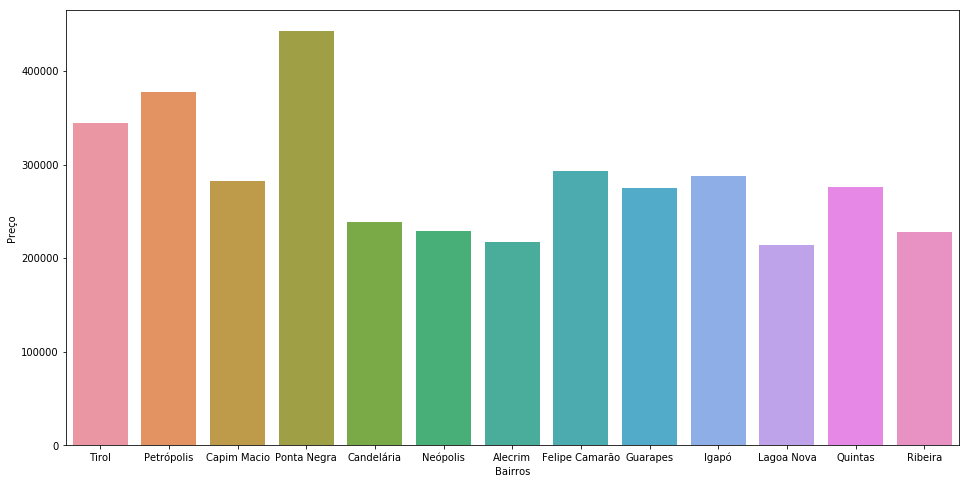

In [0]:
# Results
lat_list = [v[0] for _, v in neig_coord.items()]
lon_list = [v[1] for _, v in neig_coord.items()]
results_df = pd.DataFrame({ 'Bairros': neighborhood,
                            'Preço': neig_final_predictions,
                            'Latitude': lat_list,
                            'Longitude':lon_list})

# Plot size
fig, ax = plt.subplots(figsize=(16, 8))

# Barplot
sns.barplot(x="Bairros", y="Preço", data=results_df)


Ou ainda, mostrando os locais no mapa com `folium`, juntamente com o valor estimado para esses bairros.

In [0]:
import folium
from folium import plugins
from matplotlib.cm import get_cmap
from matplotlib.colors import to_hex, Normalize

# Folium's Map object
m = folium.Map(location=[-5.812757, -35.255127], zoom_start=12)
df = results_df
# Iterate over df 
for i, obs in df.iterrows():
    tooltip = str(obs['Bairros'])
    popup = "Valor estimado: R$" + "{0:.0f}K".format((obs['Preço'] / 1000))
    folium.Marker( location=[ obs['Latitude'], obs['Longitude'] ], tooltip=tooltip, popup=popup).add_to(m)

# Visualization and saving
m.save( 'm2.html')
#HTML(filename="m2.html")
m